# Identify tesk-modulated electrodes
See Voytek, 2015 for procedural example; analogous to common single-unit analyses, we will identify task-modulated electrodes.

## Setup

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

### Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum



In [3]:
import sys
sys.path.append(f"{PROJECT_PATH}/code")
from plots import plot_tfr
from utils import zscore_tfr, crop_tfr, subtract_baseline, downsample_tfr
from stats import gen_random_order, shuffle_rows, comp_resampling_pval

### Settings

In [4]:
# choose example condition
# FNAME = 'tfr_words_hit_multitaper.json'

In [5]:
# dataset details
FS = 512 # sampling frequency
TMIN = -1.5 # epoch start time
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22']

In [6]:
# Specparam parameters
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'           :   'knee'}

# power analysis (will remove edge artifacts)
WINDOW = 1 # window size for pre/post stimulus power analysis
EDGE = 0.3 # window size for spectral decomposition
N_DOWNSAMPLE = 128 

# band anlysis
BANDS = Bands({'alpha' : [8, 20]})

### Functions

## Main

### Load example spectrogram data and parmeters

In [7]:
# load example tfr param results

# init
example_index = 1
dir_input = f"{PROJECT_PATH}/data/ieeg_tfr_param/"
files = os.listdir(dir_input)
files = [f for f in files if f.endswith('.json')]
file = files[example_index]

# load param results
fg = FOOOFGroup()
fg.load(f"{dir_input}/{file}")

#extract parameters
exp = fg.get_params('aperiodic_params', 'exponent')
alpha = get_band_peak_fg(fg, [8, 20])

# print
print(f"Example file: {file}")
print(f"exponent shape: {exp.shape}")
print(f"exponent mean: {np.mean(exp):.2f}")
print(f"exponent std: {np.std(exp):.2f}")
print(f"alpha shape: {alpha.shape}")
print(f"alpha mean: {np.mean(alpha, axis=0)}")
print(f"alpha std: {np.std(alpha, axis=0)}")

Example file: pat02_faces_hit_chan0_tfr_multitaper_param_knee.json
exponent shape: (128,)
exponent mean: 3.28
exponent std: 0.27
alpha shape: (128, 3)
alpha mean: [nan nan nan]
alpha std: [nan nan nan]


c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


tfr shape: (49, 128, 2049)
freq shape: (128,)
time shape: (2049,)


Text(0.5, 1.0, 'Example spectrogram')

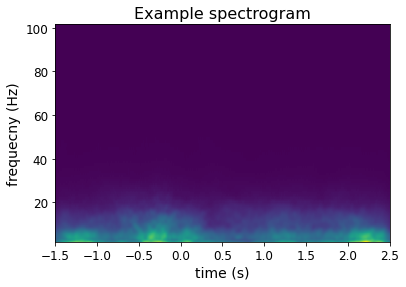

In [8]:
# load tfr
dir_input = f"{PROJECT_PATH}/data/ieeg_tfr/"
fname_in = file.replace('_param', '').replace('_fixed','').replace('_knee', '').replace('.json', '.npz')
data_in = np.load(f"{dir_input}/{fname_in}")
tfr = np.squeeze(data_in['tfr'])
freq = data_in['freq']
time = data_in['time']

# print
print(f"tfr shape: {tfr.shape}")
print(f"freq shape: {freq.shape}")
print(f"time shape: {time.shape}")

# plot
fig, ax = plt.subplots()
ax.pcolormesh(time, freq, np.mean(tfr,axis=0), cmap='viridis')
ax.set(xlabel="time (s)", ylabel="frequecny (Hz)")
ax.set_title("Example spectrogram")


In [9]:
print(f"tfr shape: {tfr.shape}")
print(f"time shape: {time.shape}")
tfr_ds, time_ds = downsample_tfr(tfr, time, N_DOWNSAMPLE)
print(f"tfr_ds shape: {tfr_ds.shape}")
print(f"time_ds shape: {time_ds.shape}")


tfr shape: (49, 128, 2049)
time shape: (2049,)
tfr_ds shape: (49, 128, 128)
time_ds shape: (128,)


normalized tfr shape: (128, 118)
new time shape: (118,)


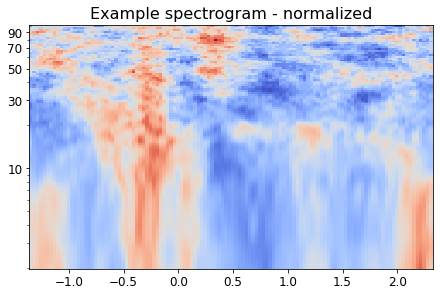

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Example spectrogram - normalized'}>)

In [10]:
 # pre-process tfr

# downsample
tfr_ds, time_ds = downsample_tfr(tfr, time, N_DOWNSAMPLE)

# average over trials
tfr_mean = np.mean(tfr_ds, axis=0)

# crop tfr (edge artiifacts)
tfr_c, time_c = crop_tfr(tfr_mean, time_ds, [time_ds[0]+(EDGE/2), time_ds[-1]-(EDGE/2)])

# normalize tfr
tfr_norm = zscore_tfr(tfr_c)

# subtract baseline
tfr_norm = subtract_baseline(tfr_norm, time_c, [time[0]+(EDGE/2), 0])

# print
print(f"normalized tfr shape: {tfr_norm.shape}")
print(f"new time shape: {time_c.shape}")

# plot
plot_tfr(time_c, freq, tfr_norm, norm_type='two_slope', title="Example spectrogram - normalized")


In [11]:
# compute alpha bandpowr time-series

# trim tfr in alpha band and average across the band
_, alpha_band_ts = trim_spectrum(freq, tfr_norm.T, f_range=BANDS['alpha'])
alpha_bp = np.mean(alpha_band_ts, axis=1)
print(f"alpha band time-series shape: {alpha_band_ts.shape}")
print(f"alpha band power shape: {alpha_bp.shape}")

alpha band time-series shape: (118, 29)
alpha band power shape: (118,)


Text(0.5, 0.98, 'Example spectral parameter timeseries')

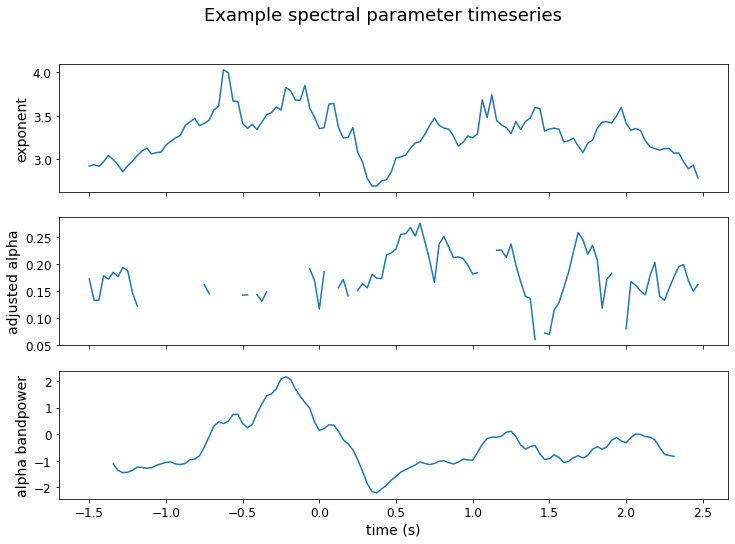

In [12]:
# plot 3 paramter time-series
fig, ax = plt.subplots(3,1, sharex=True, figsize=[12,8])
ax[0].plot(time_ds, exp)
ax[0].set(ylabel="exponent")
ax[1].plot(time_ds, alpha[:,1])
ax[1].set(ylabel="adjusted alpha")
ax[2].plot(time_c, alpha_bp)
ax[2].set(ylabel="alpha bandpower")
ax[2].set(xlabel="time (s)")
fig.suptitle("Example spectral parameter timeseries")


### Compute alpha modulation index

In [13]:
 # pre-process tfr

# 
tfr_raw = np.squeeze(data_in['tfr'])
print(tfr_raw.shape)

# crop edge artifacts of power analysis
tfr, time = crop_tfr(tfr_raw, data_in['time'], 
                     [time_ds[0]+(EDGE/2), time_ds[-1]-(EDGE/2)])
print(tfr.shape, time.shape)

# trim tfr in alpha band and average across the band
_, alpha_band_ts = trim_spectrum(freq, tfr, f_range=BANDS['alpha'])
print(alpha_band_ts.shape)

(49, 128, 2049)
(49, 128, 1879) (1879,)
(49, 29, 1879)


In [14]:
# compute mean pre/post-stimulus alpha bandpower
# alpha_pre = np.mean(alpha_bp[time < 0])
# alpha_post = np.mean(alpha_bp[time > 0])
alpha_pre = alpha_band_ts[...,time < 0]
alpha_post = alpha_band_ts[...,time > 0]

# print
print(f"alpha band power shape: {alpha_pre.shape}")
print(f"mean alpha pre-stimulus: {np.mean(alpha_pre):.2f}")
print(f"mean alpha post-stimulus: {np.mean(alpha_post):.2f}")

alpha band power shape: (49, 29, 691)
mean alpha pre-stimulus: 27640.70
mean alpha post-stimulus: 22753.84


In [59]:
def comp_alpha_bandpower(tfr, freq, time, f_range=[8, 20], window=1, edge=0.3, 
                         average=True, print_results=True):
    """Compute alpha bandpower time-series from TFR data.
    
    Parameters
    ----------
    tfr : array 
        Time-frequency representation of the signal. Can be 2 or 3 dimensional.
        If 2d, (freq x time). If 3D (trials x freq x time)
    freq : 1d array
        Frequency values.
    time : 1d array
        Time values. The length of time should match the last dimension of tfr.
    f_range : arrav of 2 floats, optional   
        Alpha frequency range, by default [8, 20].
    window : float, optional
    edge : float, optional
        Window size used power analysis. The tfr will be cropped to remove 
        edge artifacts, by default 0.3.
    average : bool, optional
        If True, average across the alpha band, by default True.
    print_results : bool, optional
        If True, print mean alpha bandpower pre/post-stimulus, by default True.
    
    Returns
    -------
    alpha_pre, alpha_post : arrays
        Alpha bandpower time-series for pre and post-stimulus periods.
    """

    # crop edge artifacts of power analysis
    tfr, time = crop_tfr(tfr, time, [time[0]+(edge/2), time[-1]-(edge/2)])

    # trim tfr in alpha band and average across the band
    _, alpha_band_ts = trim_spectrum(freq, tfr, f_range=f_range)

    # compute mean pre/post-stimulus alpha bandpower
    alpha_pre = alpha_band_ts[..., np.logical_and(time>-window, time<0)]
    alpha_post = alpha_band_ts[..., np.logical_and(time>0, time<window)]

    # average over band (if requested)
    if average:
        alpha_pre = np.mean(alpha_pre, axis=1)
        alpha_post = np.mean(alpha_post, axis=1)

    # print results
    if print_results:
        print(f"mean alpha pre-stimulus: {np.mean(alpha_pre):.2f}")
        print(f"mean alpha post-stimulus: {np.mean(alpha_post):.2f}")
    
    return alpha_pre, alpha_post

In [60]:
# apply function
alpha_pre, alpha_post = comp_alpha_bandpower(np.squeeze(data_in['tfr']), data_in['freq'], 
                                             data_in['time'], f_range=BANDS['alpha'], 
                                             edge=EDGE, window=WINDOW, print_results=True)

mean alpha pre-stimulus: 18571.54
mean alpha post-stimulus: 11370.15


mean alpha shuffled a: 14960.01
mean alpha shuffled b: 14981.68
mean shuffled difference: -21.66
Empirical change in alpha bandpower: -7201.39
p value: 0.0
Sign of difference: -1


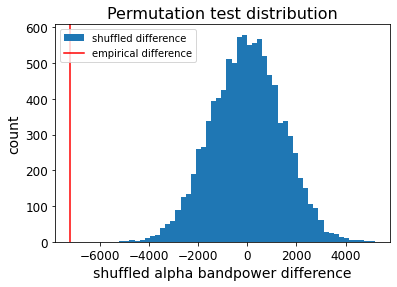

In [71]:
# permutation statistics 

# settings
i_chan = 0 # example channel 
n_iter = 10000 # number of iterations

# shuffle conditions
order = gen_random_order(n_iter, alpha_pre.shape[0]*2)
alpha_pre_shuf, alpha_post_shuf = shuffle_rows(alpha_pre, alpha_post, order)

# average over time windows and trials and compute difference
alpha_a = np.mean(alpha_post_shuf, axis=(1,2))
alpha_b = np.mean(alpha_pre_shuf, axis=(1,2))
alpha_distr = alpha_a - alpha_b
print(f"mean alpha shuffled a: {np.mean(alpha_a):.2f}")
print(f"mean alpha shuffled b: {np.mean(alpha_b):.2f}")
print(f"mean shuffled difference: {np.mean(alpha_distr):.2f}")
# print(f"% change: {np.mean(alpha_distr) / np.mean(alpha_pre[:, i_chan]):.5f}")

# compute p value
alpha_diff = np.mean(alpha_post) - np.mean(alpha_pre)
p_val, sign = comp_resampling_pval(alpha_distr, alpha_diff)
print(f'Empirical change in alpha bandpower: {alpha_diff:.2f}')
print(f"p value: {p_val}")
print(f"Sign of difference: {sign}")

# plot
plt.hist(alpha_distr, bins=50, label='shuffled difference')
plt.axvline(alpha_diff, color='r', label='empirical difference')
plt.xlabel("shuffled alpha bandpower difference")
plt.ylabel("count")
plt.title("Permutation test distribution")
plt.legend()

#### put it all together

In [73]:
# settings
n_iter = 10000 # number of iterations/shuffles for resampling analysis

# choose example file
i_file = 1 # example file
dir_input = f"{PROJECT_PATH}/data/ieeg_tfr/"
files = os.listdir(dir_input)
file = files[i_file]

In [74]:

def task_modulation(fname_in):
    # load tfr
    data_in = np.load(fname_in)

    # compute alpha bandpower for pre/post-stim time window
    alpha_pre, alpha_post = comp_alpha_bandpower(np.squeeze(data_in['tfr']), data_in['freq'], 
                                                data_in['time'], f_range=BANDS['alpha'], 
                                                edge=EDGE, window=WINDOW, average=True, 
                                                print_results=False)

    # shuffle conditions
    order = gen_random_order(n_iter, alpha_pre.shape[0]*2)
    alpha_pre_shuf, alpha_post_shuf = shuffle_rows(alpha_pre, alpha_post, order)

    # average shuffled power values over time windows and trials, then compute difference
    alpha_a = np.mean(alpha_post_shuf, axis=(1,2))
    alpha_b = np.mean(alpha_pre_shuf, axis=(1,2))
    alpha_distr = alpha_a - alpha_b

    # compute p value
    alpha_diff = np.mean(alpha_post) - np.mean(alpha_pre)
    p_val, sign = comp_resampling_pval(alpha_distr, alpha_diff)

    return p_val, sign

In [76]:
p_val, sign = task_modulation(f"{dir_input}/{file}")
if p_val==0:    
    print(f"p value < {1/n_iter}")
else:    
    print(f"p value: {p_val}")
print(f"Sign of difference: {sign}")

p value < 0.0001
Sign of difference: -1
